# A/B тестирование 

Наша задача - провести оценку результатов A/B теста. В нашем распоряжении датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. 

Нам требуется:
- оценить корректность проведения теста
- проанализировать результаты теста

Чтобы оценить корректность, проверим:
- пересечение тестовой аудитории с конкурирующим тестом
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста

Цель исследования - оценка влияния улучшений рекомендательной системы на конверсию. 

## Техническое задание
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000;
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
  - конверсии в просмотр карточек товаров — событие `product_page`,
  - просмотры корзины — `product_cart`,
  - покупки — `purchase`.

## Изучение данных из файлов

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import datetime as dt
from IPython.display import display_html
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.3f}".format)
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.simplefilter('ignore')

In [2]:
# чтение файла с данными и сохранение в датафреймы
events = pd.read_csv('../../yandex-praktikum-sources/final_ab_events.csv')
n_u = pd.read_csv('../../yandex-praktikum-sources/final_ab_new_users.csv')
part = pd.read_csv('../../yandex-praktikum-sources/final_ab_participants.csv')
m_events = pd.read_csv('../../yandex-praktikum-sources/final_ab_marketing_events.csv')

In [3]:
# просмотр информации о таблицах и проверка наличия дубликатов
d = {'events' : events, 'new users' : n_u, 'participants' : part, 'marketing events':m_events}
for a, i in d.items():
    print(f'Название датафрейма {a}, количество дубликатов {i.duplicated().sum()}')
    display(i.head())
    display(i.info())
    print('- ' * 50)

Название датафрейма events, количество дубликатов 0


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.990
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.990
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.990
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.990
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.990


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Название датафрейма new users, количество дубликатов 0


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Название датафрейма participants, количество дубликатов 0


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Название датафрейма marketing events, количество дубликатов 0


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Согласно документации к данным:

Таблица `final_ab_marketing_events.csv` — календарь маркетинговых событий на 2020 год. <br>
Структура файла:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

Таблица `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.<br>
Структура файла:
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

Таблица `final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.<br>
Структура файла:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах.

Таблица `final_ab_participants.csv` — таблица участников тестов.<br>
Структура файла:
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

Из просмотра информации о таблицах можно увидеть, что пропуски есть только в таблице `events`, столбце `details`, но так как это поле содержит дополнительную информацию, ничего страшного в пропусках нет. 

Полных дубликатов в таблицах нет.

Столбцы с датами можно преобразовать к временнОму типу данных.

In [4]:
# преобразование данных о времени
events['event_dt'] = pd.to_datetime(events['event_dt'])
n_u['first_date'] = pd.to_datetime(n_u['first_date'])
m_events['start_dt'] = pd.to_datetime(m_events['start_dt'])
m_events['finish_dt'] = pd.to_datetime(m_events['finish_dt'])

## Оценка соответствия теста техническому заданию

### Время проведения теста

Проверим, что во время проведения теста не было иных маркетинговых мероприятий, которые могли бы повлиять на результат.

In [5]:
# сохраним в переменные временные рамки теста: начало, конец, и конец набора пользователей
t_start = dt.date(2020, 12, 7)
t_finish = dt.date(2021, 1, 4)
reg_finish = dt.date(2020, 12, 21)

In [6]:
# маркетинговые события от начала до конца набора пользователей
m_events.query('not(start_dt > @reg_finish or finish_dt < @t_start)')

,name,regions,start_dt,finish_dt


In [7]:
# маркетинговые события от начала до конца теста
m_events.query('not(start_dt > @t_finish or finish_dt < @t_start)')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Во время набора пользователей на тест маркетинговых мероприятий не было, но в период с 25 декабря до 3 января проходили сразу две акции - рождественское и новогоднее промо в Европе и Североной Америке и новогодняя лотерея в СНГ. Возможно, эти акции повлияли на пользователей в последнюю неделю теста. 

### Выборка участников нужного теста

Проверим, участники каких тестов есть в таблице `participants`.

In [8]:
part['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Мы видим, что в таблице участники двух тестов - интересующий нас тест улучшений рекомендательной системы и другой, видимо, тест изменений интерфейса 

In [9]:
# создадим сводную таблицу по уникальным пользователям
tests_groups = part.sort_values(by='ab_test').groupby('user_id').agg({'ab_test':['last', 'nunique']}).reset_index()
# переименуем столбцы
tests_groups.set_axis(['user_id', 'test', 'tests_count'], axis='columns', inplace=True)

print(f'Пользователи, участвовавшие сразу в двух тестах: {len(tests_groups.query("tests_count == 2"))}')

q = '(test == "interface_eu_test") and (tests_count == 1)'
print(f'Пользователи, участвовашие только в тесте изменений интерфейса: {len(tests_groups.query(q))}')

q = '(test == "recommender_system_test") and (tests_count == 1)'
print(f'Пользователи, участвовавшие только в тесте рекомендательной системы: {len(tests_groups.query(q))}')

Пользователи, участвовавшие сразу в двух тестах: 1602
Пользователи, участвовашие только в тесте изменений интерфейса: 9965
Пользователи, участвовавшие только в тесте рекомендательной системы: 5099


Всего таблице 16666 пользователей, из которых 1602 участвовали в обоих тестах, 9965 - в тесте изменений интерфейса и 5099 - в интересующем нас тесте улучшений рекомендаций. 5099 - на 15% меньше, чем ожидаемые 6000.  

Можем оставить в тесте тех пользователей, которые были в контрольной группе второго теста и их коснулись только важные для нас изменения.

Для дальнейшего анализа отсеем лишних пользователей.

In [10]:
interface_test_a = list(part.query('ab_test=="interface_eu_test" and group=="A"')['user_id'])
q = '(tests_count == 2) and (user_id in @interface_test_a)'
print(f'Пользователи, участвовавшие в двух тестах, но в тесте интерфейса попавшие в контрольную группу: {len(tests_groups.query(q))}')

Пользователи, участвовавшие в двух тестах, но в тесте интерфейса попавшие в контрольную группу: 819


In [11]:
recom_test_users = list(tests_groups.query('(test == "recommender_system_test" and tests_count == 1) or (tests_count == 2) and (user_id in @interface_test_a)')['user_id'])
target_users = part.query('user_id in @recom_test_users and ab_test == "recommender_system_test"')

target_users.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


### Распределение пользователей по группам 

Проверим, нет ли пользователей, попавших одновременно в обе группы.

In [12]:
doubles = target_users.groupby('user_id').agg({'group' : 'nunique', 'ab_test':'nunique'}).reset_index()
doubles = doubles[(doubles.ab_test == 1) & (doubles.group == 2)]
print(f'Всего уникальных пользователей среди участников теста: {len(target_users["user_id"].unique())}')
print(f'Пользователей, попавших в обе группы: {len(doubles)}')
print(f'Доля неверно распределенных пользователей {len(doubles) / len(target_users["user_id"].unique()):.2%}')

Всего уникальных пользователей среди участников теста: 5918
Пользователей, попавших в обе группы: 0
Доля неверно распределенных пользователей 0.00%


Пользователей, попавших в обе группы, нет. Участники распределены корректно.

Проверим также, что пользователи распределены по группам равномерно.

In [13]:
test_parts = target_users.groupby('group').agg({'user_id':'nunique'}).reset_index()
test_parts['%_total'] = test_parts['user_id'] / test_parts.user_id.sum()
test_parts

,group,user_id,%_total
0,A,3385,0.572
1,B,2533,0.428


Распределение не слишком ровное - пользователей в группе А на треть больше, чем в группе B.

### Распределение пользователей по регионам

Проверим, что выполнено условие ТЗ - в тест попали 15% новых пользователей из региона EU. Поделим количество пользователей из Европы, попавших в тест, на общее количество пользователей из Европы, при условии, что дата их регистрации попадает в интервал набора пользователей.

In [14]:
(
    len(n_u.query('(user_id in @recom_test_users) and (region == "EU") and (first_date <= @reg_finish) and (first_date >= @t_start)')) 
    / len(n_u.query('(region == "EU") and (first_date <= @reg_finish) and (first_date >= @t_start)'))
)

0.13150684931506848

Около 13% новых пользователей из Европы, зарегистрировавшихся с 7 по 21 декабря, попали в тест. Это меньше, чем доля по ТЗ - 15%.

### Распределение событий по времени

In [15]:
events['date'] = events['event_dt'].dt.date

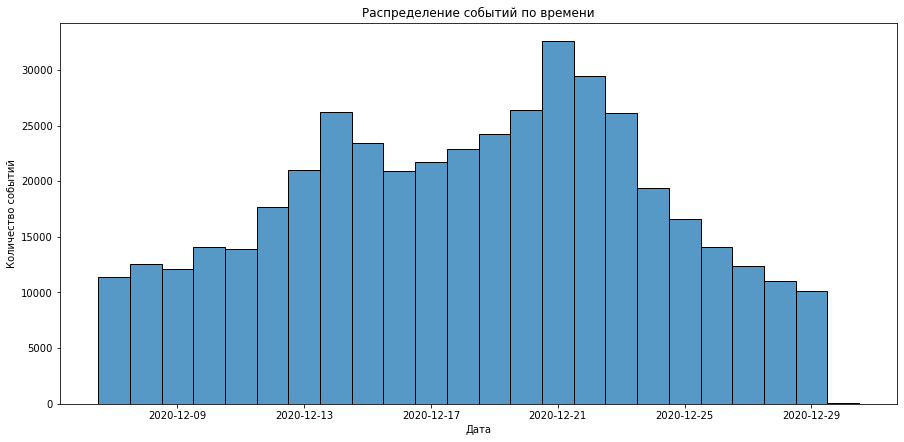

In [16]:
plt.figure(figsize=(15, 7))
sns.histplot(x='date', data=events, palette='crest')
plt.title('Распределение событий по времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

В целом события распределены равномерно, пик около 21 декабря объясним ажиотажем перед Рождеством. 

Однако несмотря на то, что окончание теста заявлено 4 января, события в таблице заказчиваются 30 декабря.

### Выводы 

Корректность проведения теста можно оценить как не очень высокую. 

1. Число новых пользователей, участвовавших в тесте, меньше ожидаемого - 5099 вместо 6000;
2. Распределение пользователей по группам (контрольной и тестовой) неравномерное, контрольная группа в полтора раза больше тестовой;
3. Доля новых пользователей из Европы, попавших в тест - 11% вместо ожидаемых 15%;
4. Во время проведения теста проводились маркетинговые кампании, которые могли исказить результаты теста;
1. События в собранных данных обрываются раньше озвученного окончания теста.

Таким образом, условия, указанные в техническом задании, не выполнены. 

Проанализировать результаты теста все еще возможно, но оценка результатов, возможно, будет искаженной. 

In [17]:
# всего число событий в данных
len(events)

440317

In [18]:
# присоединим дату первого визита
events = events.merge(n_u[['user_id', 'first_date']], on='user_id', how='left')
events['date'] = pd.to_datetime(events['date'])
# подсчитаем временной промежуток от первого до текущего события
events['delta'] = events['date'] - events['first_date']

In [19]:
# зададим горизонт - 14 дней
d14 = pd.Timedelta(days=14)
# отфильтруем те, которые в него не попадают
events = events[events['delta'] <= d14].copy()
# посмотрим, сколько осталось событий
len(events)

424906

Временным горизонтом в 14 дней мы отсеиваем около 5% событий.

## Анализ A/B теста

### Подготовка исходных таблиц

Создадим таблицы с событиями, связанными соответственно с пользователями групп А и В теста.

In [20]:
a = list(target_users.query('group == "A"')['user_id'])
events_a = events.query('user_id in @a')
events_a['date'] = events_a['event_dt'].dt.date
events_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16821 entries, 5 to 440267
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   user_id     16821 non-null  object         
 1   event_dt    16821 non-null  datetime64[ns] 
 2   event_name  16821 non-null  object         
 3   details     2319 non-null   float64        
 4   date        16821 non-null  object         
 5   first_date  16821 non-null  datetime64[ns] 
 6   delta       16821 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), object(3), timedelta64[ns](1)
memory usage: 1.0+ MB


In [21]:
events_a.head()

,user_id,event_dt,event_name,details,date,first_date,delta
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.990,2020-12-07,2020-12-07,0 days
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.990,2020-12-07,2020-12-07,0 days
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.990,2020-12-07,2020-12-07,0 days
106,538F954F6B3AECE4,2020-12-07 07:12:05,purchase,4.990,2020-12-07,2020-12-07,0 days
269,DD5EBF41B1DCCB0E,2020-12-07 19:21:29,purchase,4.990,2020-12-07,2020-12-07,0 days


In [22]:
b = list(target_users.query('group == "B"')['user_id'])
events_b = events.query('user_id in @b')
events_b['date'] = events_b['event_dt'].dt.date
events_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4455 entries, 58 to 440096
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   user_id     4455 non-null   object         
 1   event_dt    4455 non-null   datetime64[ns] 
 2   event_name  4455 non-null   object         
 3   details     547 non-null    float64        
 4   date        4455 non-null   object         
 5   first_date  4455 non-null   datetime64[ns] 
 6   delta       4455 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), object(3), timedelta64[ns](1)
memory usage: 278.4+ KB


In [23]:
events_b.head()

,user_id,event_dt,event_name,details,date,first_date,delta
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.990,2020-12-07,2020-12-07,0 days
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.990,2020-12-07,2020-12-07,0 days
118,A9908F62C41613A8,2020-12-07 11:26:47,purchase,9.990,2020-12-07,2020-12-07,0 days
146,0997EC1C4850B27B,2020-12-07 08:01:55,purchase,4.990,2020-12-07,2020-12-07,0 days
155,C7CB2F1BA42F102B,2020-12-07 03:05:05,purchase,99.990,2020-12-07,2020-12-07,0 days


Уже по информации о полученных таблицах видно, что неравномерность разбивки играет роль - событий в большей группе больше почти в три раза.

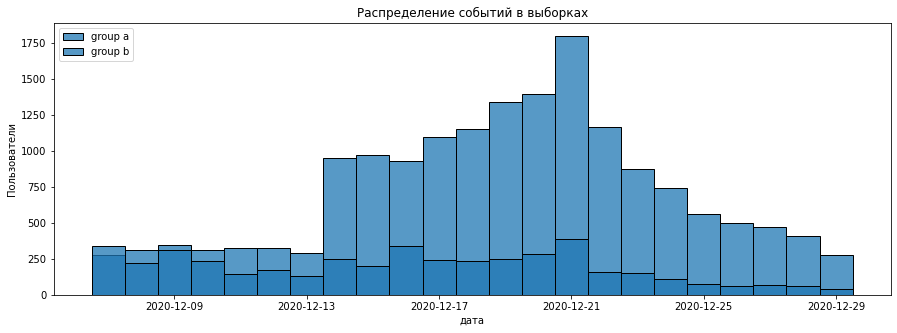

In [24]:
# распределение событий в выборках
fig, ax = plt.subplots(sharex=True, figsize=(15, 5))
sns.histplot(x='date', data=events_a, label='group a')
sns.histplot(x='date', data=events_b, label='group b')
plt.title('Распределение событий в выборках')
plt.xlabel('дата')
plt.ylabel('Пользователи')
plt.legend(loc='upper left')
plt.show()

В группе B события по времени распределены более равномерно, чем в группе А - в ней можно заметить резкий скачок 14 декабря. 

Проверим, нормально ли распределены события по пользователям в выборках, и есть ли разница в том, сколько событий приходится на пользователя.

In [25]:
# проверим распределения на нормальность
alpha = 0.05  # критический уровень статистической значимости

p_value = st.shapiro(list(events_a.groupby('user_id')['event_name'].count()))[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение группы А не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение группы А нормально') 
    
p_value = st.shapiro(list(events_b.groupby('user_id')['event_name'].count()))[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение группы B не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение группы B нормально') 

p-значение:  1.6049962930547426e-33
Отвергаем нулевую гипотезу: распределение группы А не нормально
p-значение:  1.552992746696575e-25
Отвергаем нулевую гипотезу: распределение группы B не нормально


In [26]:
# сравним выборки с помощтю U-критерия
results = st.mannwhitneyu(list(events_a.groupby('user_id')['event_name'].count()),
                          list(events_b.groupby('user_id')['event_name'].count()))

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  1.7919101265767045e-26
Отвергаем нулевую гипотезу: разница статистически значима


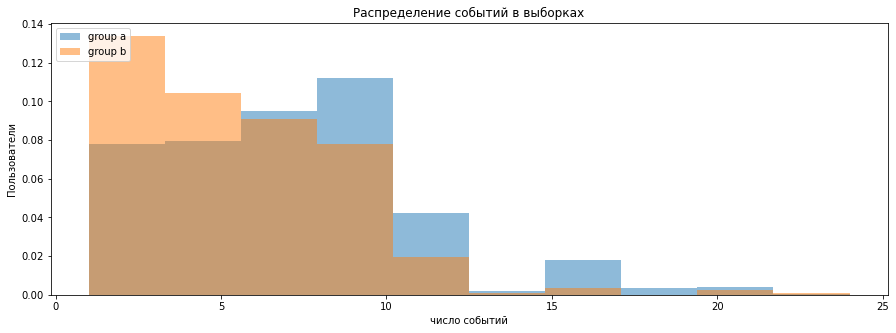

In [27]:
# построим графики
fig, ax = plt.subplots(sharex=True, figsize=(15, 5))
ax.hist(events_a.groupby('user_id')['event_name'].count(), label='group a', alpha=0.5, density=True)
ax.hist(events_b.groupby('user_id')['event_name'].count(), label='group b', alpha=0.5, density=True)
plt.title('Распределение событий в выборках')
plt.xlabel('число событий')
plt.ylabel('Пользователи')
plt.legend(loc='upper left')
plt.show()

In [28]:
print(events_a.groupby('user_id')['event_name'].count().mean())
print(events_b.groupby('user_id')['event_name'].count().mean())

6.945086705202312
5.41970802919708


Таким образом, события по пользователям распределены не только не нормально, но и по-разному в  зависимости от группы.

### Кумулятивные метрики - новые пользователи

Подсчитаем прирост количества новых пользователей от начала теста в каждой группе.

In [29]:
# отделим информацию о новых пользователях по группам теста
new_users_a = n_u.query('user_id in @a')
new_users_b = n_u.query('user_id in @b')

In [30]:
# группа А
new_users_a_cummulative = new_users_a.groupby('first_date')['user_id'].count().reset_index()
new_users_a_cummulative['new_users'] = new_users_a_cummulative['user_id'].cumsum()
# new_users_a_cummulative

In [31]:
# группа B
new_users_b_cummulative = new_users_b.groupby('first_date')['user_id'].count().reset_index()
new_users_b_cummulative['new_users'] = new_users_b_cummulative['user_id'].cumsum()
# new_users_b_cummulative

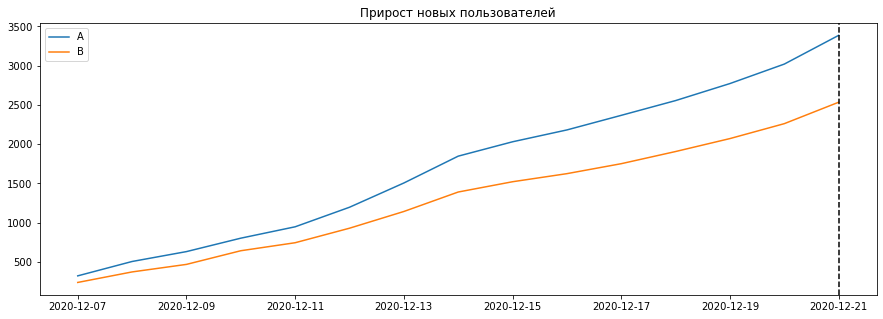

In [32]:
# построим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(new_users_a_cummulative.first_date, new_users_a_cummulative.new_users, label = 'A')
ax.plot(new_users_b_cummulative.first_date, new_users_b_cummulative.new_users, label = 'B')
plt.legend()
plt.axvline(x=reg_finish, color='black', linestyle='--')
plt.title('Прирост новых пользователей')
plt.show()

### Кумулятивные метрики - логины

Подсчитаем прирост входов в систему новых пользователей.

In [33]:
# группа А
login_agg_a = (
    events_a.apply(lambda x:events_a[np.logical_and(events_a['date'] < x['date'], 
                                                    events_a['event_name'] == 'login')]
                   .agg({'date' : 'max', 'user_id' : 'nunique'}), axis=1).sort_values('date')
)
login_agg_a = login_agg_a.groupby('date')[['user_id']].mean().reset_index()
# login_agg_a = login_agg_a.query('date <= @reg_finish')

In [34]:
# группа B
login_agg_b = (
    events_b.apply(lambda x:events_b[np.logical_and(events_b['date'] < x['date'], 
                                                    events_b['event_name'] == 'login')]
                   .agg({'date' : 'max', 'user_id' : 'nunique'}), axis=1).sort_values('date')
)
login_agg_b = login_agg_b.groupby('date')[['user_id']].mean().reset_index()
# login_agg_b = login_agg_b.query('date <= @reg_finish')

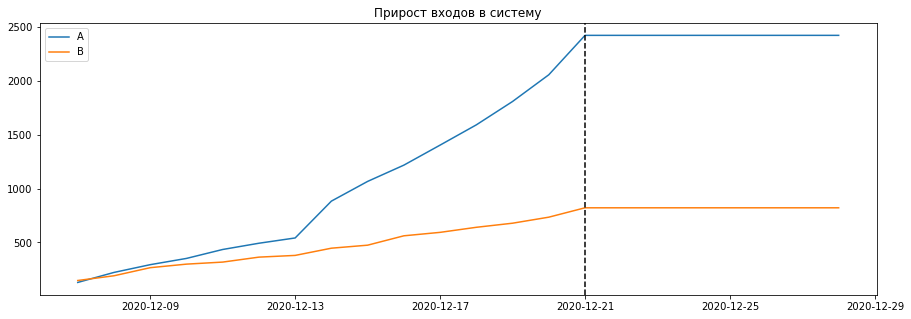

In [35]:
# построим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(login_agg_a.date, login_agg_a.user_id, label = 'A')
ax.plot(login_agg_b.date, login_agg_b.user_id, label = 'B')
plt.legend()
plt.axvline(x=reg_finish, color='black', linestyle='--')
plt.title('Прирост входов в систему')
plt.show()

### Кумулятивные метрики - просмотры товаров

Подсчитаем прирост просмотров страниц товара новыми пользователями. 

In [36]:
# группа А
product_views_agg_a = (
    events_a.apply(lambda x:events_a[np.logical_and(events_a['date'] < x['date'], 
                                                    events_a['event_name'] == 'product_page')]
                   .agg({'date' : 'max', 'user_id' : 'nunique'}), axis=1).sort_values('date')
)
product_views_agg_a = product_views_agg_a.groupby('date')[['user_id']].mean().reset_index()
# product_views_agg_a = product_views_agg_a.query('date <= @reg_finish')

In [37]:
# группа B
product_views_agg_b = (
    events_b.apply(lambda x:events_b[np.logical_and(events_b['date'] < x['date'], 
                                                    events_b['event_name'] == 'product_page')]
                   .agg({'date' : 'max', 'user_id' : 'nunique'}), axis=1).sort_values('date')
)
product_views_agg_b = product_views_agg_b.groupby('date')[['user_id']].mean().reset_index()
# product_views_agg_b = product_views_agg_b.query('date <= @reg_finish')

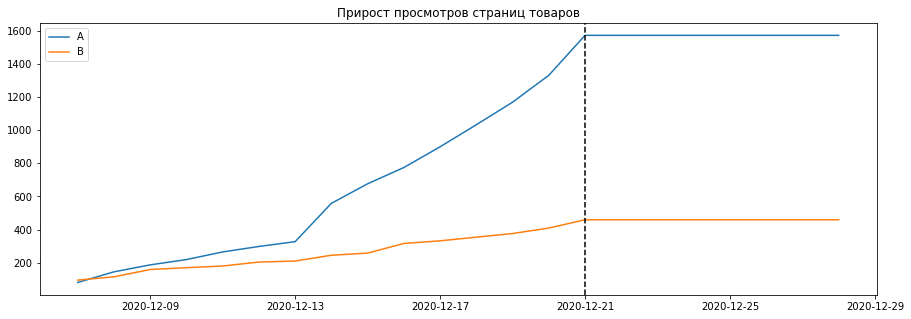

In [38]:
# построим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(product_views_agg_a.date, product_views_agg_a.user_id, label = 'A')
ax.plot(product_views_agg_b.date, product_views_agg_b.user_id, label = 'B')
plt.legend()
plt.axvline(x=reg_finish, color='black', linestyle='--')
plt.title('Прирост просмотров страниц товаров')
plt.show()

### Кумулятивные метрики - просмотры корзины

Подсчитаем прирост просмотров страницы корзины новыми пользователями. 

In [39]:
# группа А
cart_views_agg_a = (
    events_a.apply(lambda x:events_a[np.logical_and(events_a['date'] < x['date'], 
                                                    events_a['event_name'] == 'product_cart')]
                   .agg({'date' : 'max', 'user_id' : 'nunique'}), axis=1).sort_values('date')
)
cart_views_agg_a = cart_views_agg_a.groupby('date')[['user_id']].mean().reset_index()
# cart_views_agg_a = cart_views_agg_a.query('date <= @reg_finish')

In [40]:
# группа B
cart_views_agg_b = (
    events_b.apply(lambda x:events_b[np.logical_and(events_b['date'] < x['date'], 
                                                    events_b['event_name'] == 'product_cart')]
                   .agg({'date' : 'max', 'user_id' : 'nunique'}), axis=1).sort_values('date')
)
cart_views_agg_b = cart_views_agg_b.groupby('date')[['user_id']].mean().reset_index()
# cart_views_agg_b = cart_views_agg_b.query('date <= @reg_finish')

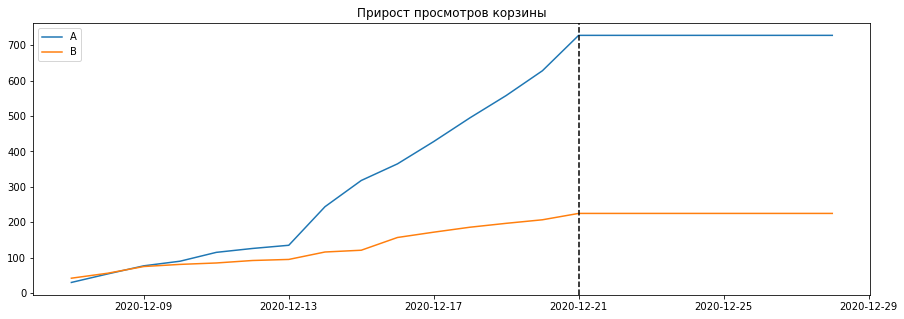

In [41]:
# построим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(cart_views_agg_a.date, cart_views_agg_a.user_id, label = 'A')
ax.plot(cart_views_agg_b.date, cart_views_agg_b.user_id, label = 'B')
plt.legend()
plt.axvline(x=reg_finish, color='black', linestyle='--')
plt.title('Прирост просмотров корзины')
plt.show()

### Кумулятивные метрики - покупки

Подсчитаем еще одну кумулятивную метрику - прирост количества совершенных новыми пользователями покупок. 

In [42]:
# группа А
purchase_agg_a = (
    events_a.apply(lambda x:events_a[np.logical_and(events_a['date'] < x['date'], 
                                                    events_a['event_name'] == 'purchase')]
                   .agg({'date' : 'max', 'user_id' : 'nunique'}), axis=1).sort_values('date')
)
purchase_agg_a = purchase_agg_a.groupby('date')[['user_id']].mean().reset_index()
# purchase_agg_a = purchase_agg_a.query('date <= @reg_finish')

In [43]:
# группа B
purchase_agg_b = (
    events_b.apply(lambda x:events_b[np.logical_and(events_b['date'] < x['date'], 
                                                    events_b['event_name'] == 'purchase')]
                   .agg({'date' : 'max', 'user_id' : 'nunique'}), axis=1).sort_values('date')
)
purchase_agg_b = purchase_agg_b.groupby('date')[['user_id']].mean().reset_index()
# purchase_agg_b = purchase_agg_b.query('date <= @reg_finish')

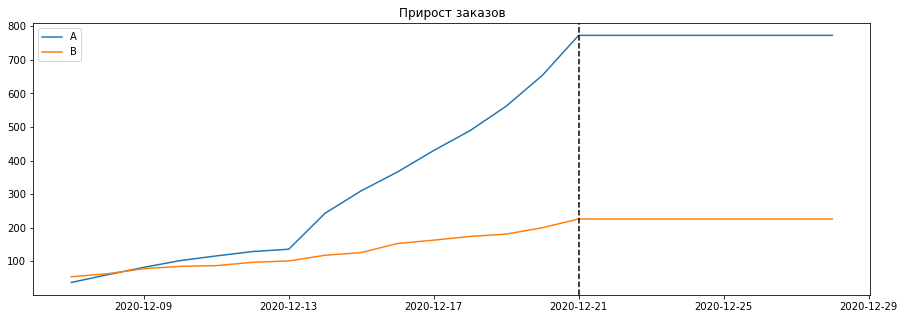

In [44]:
# построим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(purchase_agg_a.date, purchase_agg_a.user_id, label = 'A')
ax.plot(purchase_agg_b.date, purchase_agg_b.user_id, label = 'B')
plt.legend()
plt.axvline(x=reg_finish, color='black', linestyle='--')
plt.title('Прирост заказов')
plt.show()

### Кумулятивные метрики - выручка

Подсчитаем еще одну кумулятивную метрику - прирост выручки.

In [45]:
# группа А
revenue_agg_a = (
    events_a.apply(lambda x:events_a[events_a['date'] < x['date']]
                   .agg({'date' : 'max', 'details' : 'sum'}), axis=1).sort_values('date')
)
revenue_agg_a = revenue_agg_a.groupby('date')[['details']].mean().reset_index()
# revenue_agg_a = revenue_agg_a.query('date <= @reg_finish')

In [46]:
# группа B
revenue_agg_b = (
    events_b.apply(lambda x:events_b[events_b['date'] < x['date']]
                   .agg({'date' : 'max', 'details' : 'sum'}), axis=1).sort_values('date')
)
revenue_agg_b = revenue_agg_b.groupby('date')[['details']].mean().reset_index()
# revenue_agg_b = revenue_agg_b.query('date <= @reg_finish')

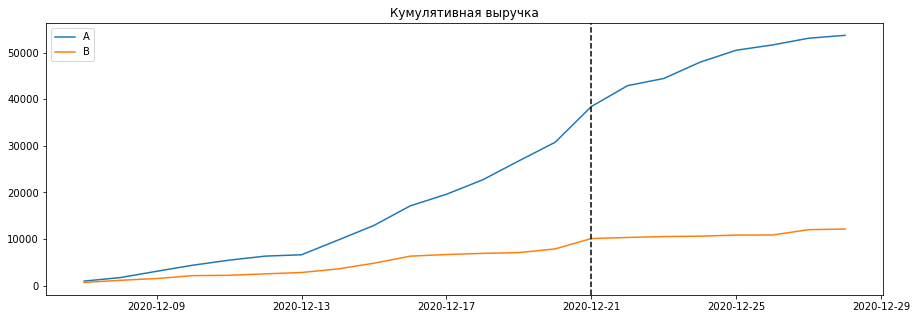

In [47]:
# построим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(revenue_agg_a.date, revenue_agg_a.details, label = 'A')
ax.plot(revenue_agg_b.date, revenue_agg_b.details, label = 'B')
plt.legend()
plt.axvline(x=reg_finish, color='black', linestyle='--')
plt.title('Кумулятивная выручка')
plt.show()

Выручка в обеих группах увеличивается на протяжении всего теста без резких всплесков.

### Кумулятивный средний чек

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

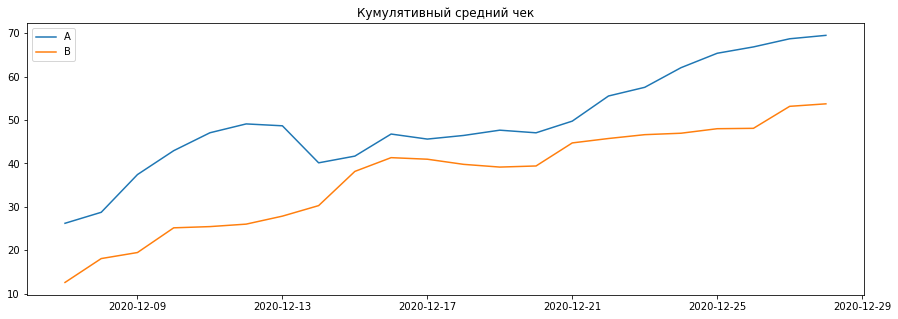

In [48]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(revenue_agg_a.date, revenue_agg_a.details / purchase_agg_a.user_id, label = 'A')
ax.plot(revenue_agg_b.date, revenue_agg_b.details / purchase_agg_b.user_id, label = 'B')
plt.legend()
plt.title('Кумулятивный средний чек')
plt.show()

Средний чек в обеих группах подрос, но в группе B стабильно ниже на пртяжении всего периода данных. 

В группе А в районе 14 декаюря можно заметить падение - видимо, большой приток пользователей с небольшими заказами размыл средний чек.

### Относительные метрики

In [49]:
# соберем полученные данные по дням в единые таблицы
a_cummulative = new_users_a_cummulative.rename(columns={'first_date':'date','user_id':'daily_new_users'})

login_agg_a['date'] = pd.to_datetime(login_agg_a['date'])
a_cummulative = pd.merge(a_cummulative, login_agg_a, on='date', how='outer').rename(columns={'user_id':'logins'})

a_cummulative['product_views'] = product_views_agg_a['user_id']
a_cummulative['cart_views'] = cart_views_agg_a['user_id']
a_cummulative['purchases'] = purchase_agg_a['user_id']
a_cummulative['revenue'] = revenue_agg_a['details']

a_cummulative = a_cummulative.fillna(0)
# a_cummulative

In [50]:
# соберем полученные данные по дням в единые таблицы
# соберем полученные данные по дням в единые таблицы
b_cummulative = new_users_b_cummulative.rename(columns={'first_date':'date','user_id':'daily_new_users'})
login_agg_b['date'] = pd.to_datetime(login_agg_b['date'])
b_cummulative = pd.merge(b_cummulative, login_agg_b, on='date', how='outer').rename(columns={'user_id':'logins'})

b_cummulative['product_views'] = product_views_agg_b['user_id']
b_cummulative['cart_views'] = cart_views_agg_b['user_id']
b_cummulative['purchases'] = purchase_agg_b['user_id']
b_cummulative['revenue'] = revenue_agg_b['details']

b_cummulative = b_cummulative.fillna(0)
# b_cummulative

In [51]:
# конверсия в просмотр карточек товаров
a_cummulative['conv_pr_page'] = a_cummulative['product_views'] / a_cummulative['new_users']
b_cummulative['conv_pr_page'] = b_cummulative['product_views'] / b_cummulative['new_users']

# конверсия в просмотр корзины
a_cummulative['conv_cart'] = a_cummulative['cart_views'] / a_cummulative['new_users']
b_cummulative['conv_cart'] = b_cummulative['cart_views'] / b_cummulative['new_users']

# конверсия в покупки
a_cummulative['conv_purchase'] = a_cummulative['purchases'] / a_cummulative['new_users']
b_cummulative['conv_purchase'] = b_cummulative['purchases'] / b_cummulative['new_users']

In [52]:
b_cummulative

,date,daily_new_users,new_users,logins,product_views,cart_views,purchases,revenue,conv_pr_page,conv_cart,conv_purchase
0,2020-12-07,237.000,237.000,146.000,95.000,42.000,54.000,679.460,0.401,0.177,0.228
1,2020-12-08,134.000,371.000,190.000,115.000,56.000,63.000,1139.160,0.310,0.151,0.170
2,2020-12-09,96.000,467.000,265.000,159.000,75.000,78.000,1518.830,0.340,0.161,0.167
3,2020-12-10,174.000,641.000,298.000,170.000,81.000,85.000,2138.610,0.265,0.126,0.133
4,2020-12-11,102.000,743.000,317.000,180.000,85.000,87.000,2213.490,0.242,0.114,0.117
5,2020-12-12,185.000,928.000,363.000,204.000,92.000,97.000,2523.270,0.220,0.099,0.105
6,2020-12-13,213.000,1141.000,379.000,210.000,95.000,101.000,2813.080,0.184,0.083,0.089
7,2020-12-14,248.000,1389.000,446.000,245.000,116.000,118.000,3572.770,0.176,0.084,0.085
8,2020-12-15,131.000,1520.000,474.000,258.000,121.000,126.000,4807.520,0.170,0.080,0.083
9,2020-12-16,103.000,1623.000,561.000,316.000,157.000,153.000,6322.070,0.195,0.097,0.094


Построим графики конверсий для всех этапов движения пользователя.

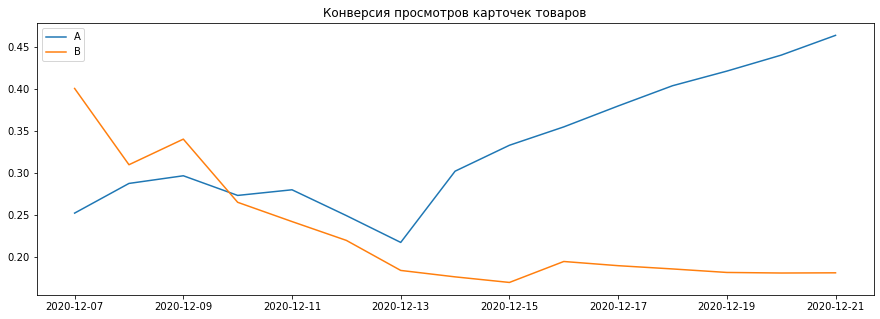

In [53]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(a_cummulative.date, a_cummulative.conv_pr_page, label = 'A')
ax.plot(b_cummulative.date, b_cummulative.conv_pr_page, label = 'B')
plt.legend()
plt.title('Конверсия просмотров карточек товаров')
plt.show()

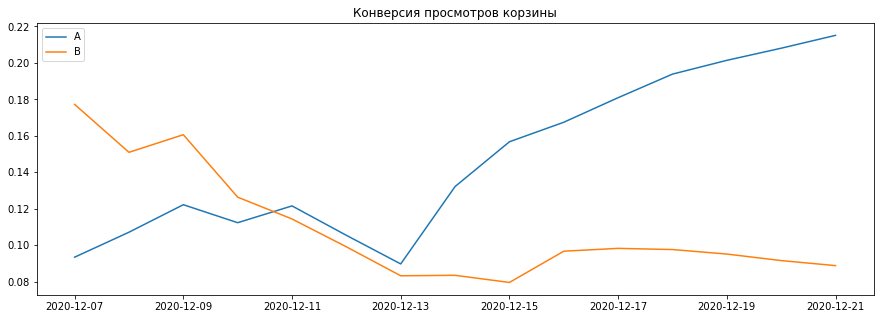

In [54]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(a_cummulative.date, a_cummulative.conv_cart, label = 'A')
ax.plot(b_cummulative.date, b_cummulative.conv_cart, label = 'B')
plt.legend()
plt.title('Конверсия просмотров корзины')
plt.show()

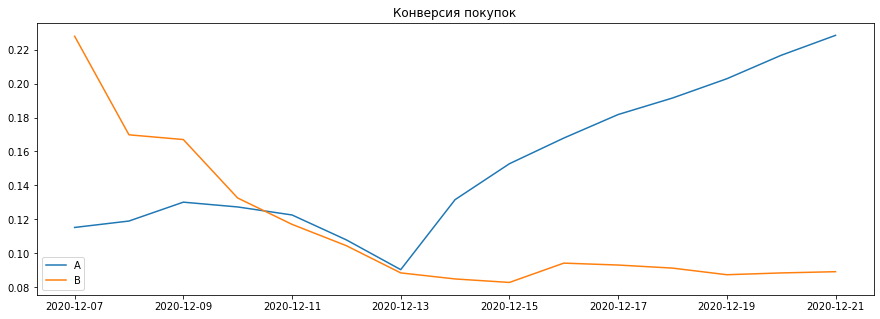

In [55]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(a_cummulative.date, a_cummulative.conv_purchase, label = 'A')
ax.plot(b_cummulative.date, b_cummulative.conv_purchase, label = 'B')
plt.legend()
plt.title('Конверсия покупок')
plt.show()

Построим график прироста конверсий в группе B относительно группы А.

In [56]:
end_date = min(a_cummulative['date'].max(), b_cummulative['date'].max())

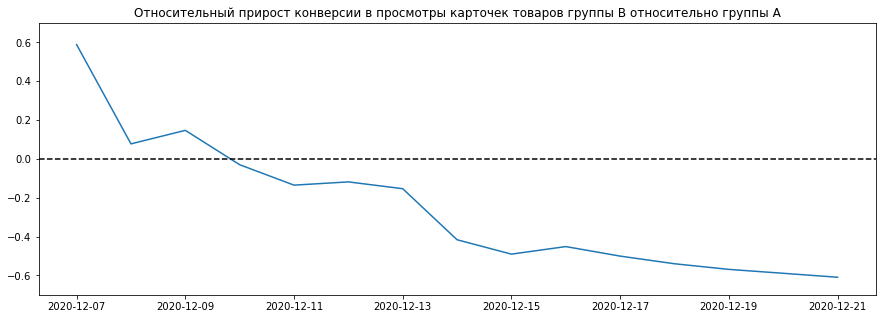

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(a_cummulative.query('date <= @end_date').date, 
        b_cummulative.query('date <= @end_date')['conv_pr_page']/a_cummulative.query('date <= @end_date')['conv_pr_page'] - 1)
plt.title('Относительный прирост конверсии в просмотры карточек товаров группы B относительно группы A')
plt.ylim(-0.7, 0.7)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

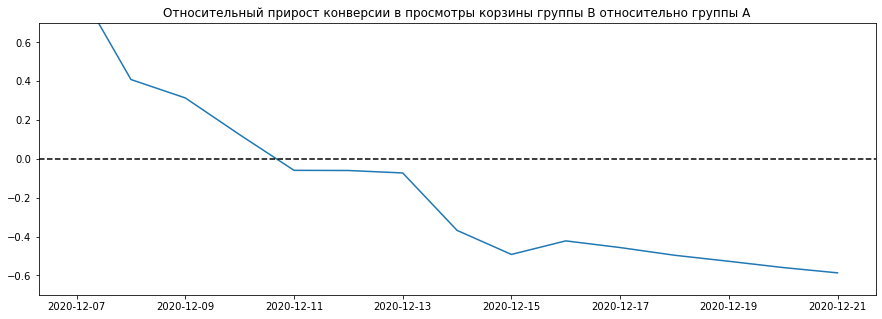

In [58]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(a_cummulative.query('date <= @end_date').date, 
        b_cummulative.query('date <= @end_date')['conv_cart']/a_cummulative.query('date <= @end_date')['conv_cart'] - 1)
plt.title('Относительный прирост конверсии в просмотры корзины группы B относительно группы A')
plt.ylim(-0.7, 0.7)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

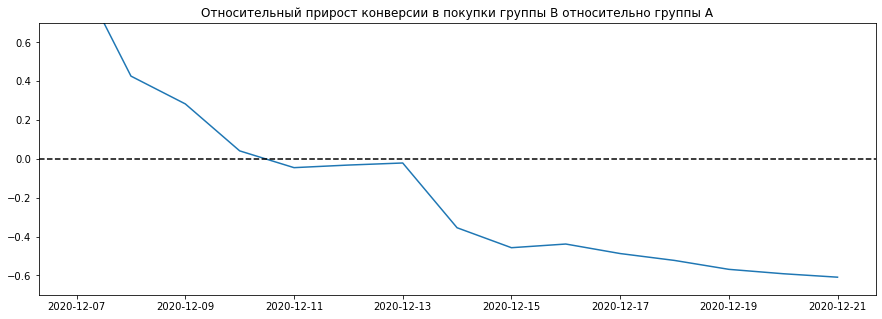

In [59]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(a_cummulative.query('date <= @end_date').date, 
        b_cummulative.query('date <= @end_date')['conv_purchase']/a_cummulative.query('date <= @end_date')['conv_purchase'] - 1)
plt.title('Относительный прирост конверсии в покупки группы B относительно группы A')
plt.ylim(-0.7, 0.7)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

### Выводы 

По всем метрикам группа B заметно проигрывает группе А. В тестовой группе был небольшой прирост конверсий в первые дни теста, но к концу значения оказались ниже стартовых. 

Скачок в распределении событий 14 декабря заметен на всех графиках - в этот момент все метрики группы А резко идут вверх, хотя до этого начинали снижаться.

## Конверсия в воронке событий

Посмотрим еще раз, каике события встречаются в логах.

In [60]:
events['event_name'].unique() 

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Событий четыре:
- `login` - вход пользователя в систему
- `product_page` - просмотр карточки товара
- `product_cart` - просмотр корзины
- `purchase` - покупка

События образуют последовательную цепочку движения пользователя по приложению. 

Посмотрим, как на самом деле пользователи двигаются по приложению.

In [61]:
# функция для составления 
def sequence(data, user):
#     sorted_data = data.sort_values(by=['user_id', 'event_dt'])
    sorted_user = data[data['user_id']==user].sort_values(by='event_dt')
    return sorted_user['event_name'].drop_duplicates().to_list()

In [62]:
# это место очень долго считается, поэтому я применю функцию только к части событий
# порядок популярности остается +- такой же
sequence_empty=[]
for i in events_a.user_id.unique():
    sequence_empty.append([i, sequence(events_a, i)])

path_data = pd.DataFrame(sequence_empty,columns=['user_id', 'path'])
# посмотрим, что получилось
path_data['path'].value_counts().head(15)

[login]                                          444
[login, product_page]                            395
[product_page, login]                            322
[purchase, login, product_page]                  223
[purchase, login]                                156
[purchase, product_page, login]                  153
[login, product_cart]                             98
[login, product_cart, product_page]               93
[product_cart, login]                             71
[product_cart, product_page, login]               69
[product_cart, login, product_page]               58
[product_page, login, product_cart]               57
[purchase, login, product_cart, product_page]     52
[purchase, login, product_cart]                   45
[login, product_page, product_cart]               42
Name: path, dtype: int64

Четвертым по популярности идет порядок `purchase`, `login`, `product_page`, что вообще-то не очень логично.

In [63]:
# сгруппируем таблицу по событиям
event_users = events.groupby('event_name').agg({'user_id':'nunique'}).reset_index()
event_users.set_axis(['event_name', 'users_count'], axis='columns', inplace=True)
# добавитим столбец - какая доля уникальных пользователей совершала это событие
event_users['%'] = event_users.users_count / n_u['user_id'].nunique()
event_users = event_users.sort_values('users_count', ascending=False).reset_index(drop=True)

# построим воронку
event_users['funnel'] = 1
for i in range(1, 4):
    event_users.loc[i, 'funnel'] = event_users.loc[i, 'users_count'] /  (event_users.loc[i-1, 'users_count'])

event_users

,event_name,users_count,%,funnel
0,login,58683,0.951,1.000
1,product_page,38918,0.630,0.663
2,purchase,19565,0.317,0.503
3,product_cart,19280,0.312,0.985


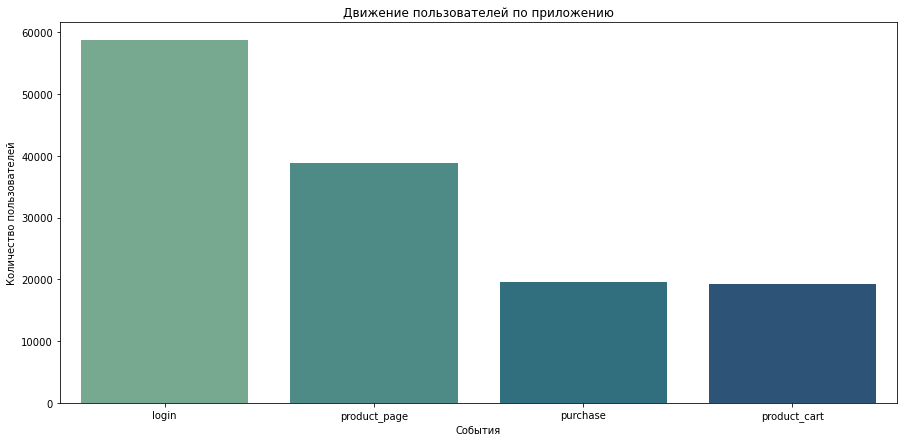

In [64]:
# построим график
plt.figure(figsize=(15, 7))
sns.barplot(data=event_users.loc[0:3], x='event_name', y='users_count', palette='crest')
plt.title('Движение пользователей по приложению')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.show()

Почти все новые пользователи залогинились в приложении, две трети смотрели карточки продуктов, треть - страницу корзины и совершала покупку, причем покупки совершало более количество пользователей, чем смотрело корзину. 

Всего покупку совершает 32% пользователей.

## Анализ результатов эксперимента

Для каждого события подсчитаем, какая доля пользователей в каждой группе его совершила, и проверим, является ли отличие между группами статистически достоверным.

**Гипотеза H0**: между долями нет значимой разницы <br>
**Гипотеза H1**: между долями есть значимая разница

In [65]:
events_groups = (events
                 .merge(target_users[['user_id','group']], on='user_id')
                 .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
                 .reset_index().sort_values('A', ascending=False).reset_index(drop=True))
events_groups = events_groups.reindex([0, 1, 3, 2]).reset_index(drop=True)
events_groups['total'] = events_groups['A'] + events_groups['B']
events_groups

group,event_name,A,B,total
0,login,2422,821,3243
1,product_page,1571,459,2030
2,product_cart,728,225,953
3,purchase,773,226,999


In [66]:
# статистическое сравнение долей 

events_groups['p-value'] = events_groups.apply(lambda row:(proportions_ztest(np.array([row['A'],
                                                                                       row['B']]),
                                                                             np.array([events_groups.loc[0, 'A'],
                                                                                       events_groups.loc[0, 'B']])))[1], axis=1)
events_groups

group,event_name,A,B,total,p-value
0,login,2422,821,3243,NaN
1,product_page,1571,459,2030,0.000
2,product_cart,728,225,953,0.149
3,purchase,773,226,999,0.019


Так как в нашем эксперименте 3 этапа в воронке, то используя поправку Бонферрони, значение alpha следует уменьшить до 0,016. 

- Для просмотра карточек товаров p-value = 0 и это меньше как 0.05, так и 0.016
- Для просмотров корзины p-value больше 0,05
- Для заказов p-value меньше 0.05, но больше 0.016

Следовательно, нулевую гипотезу не удалось отвергнуть для просмотров корзины и покупок, но не для просмотров карточек товаров. 

Статистические значимые различия между группами есть только на этапе просмотров карточек товаров, а при просмотре корзины и при покупках статистически значимых различий нет. 

## Выводы 

Почти все новые пользователи (95%) залогинились в приложении, 63% смотрели карточки продуктов, 31% - страницу корзины и 32% совершали покупку, покупки совершало более количество пользователей, чем смотрело корзину.

Всего покупку совершает 32% пользователей.

Корректность проведения теста можно оценить как не очень высокую.

- Число новых пользователей, участвовавших в тесте, немного меньше ожидаемого - 5918 вместо 6000;
- Распределение пользователей по группам (контрольной и тестовой) неравномерное, контрольная группа в полтора раза больше тестовой;
- Доля новых пользователей из Европы, попавших в тест - 13% вместо ожидаемых 15%;
- Во время проведения теста проводились маркетинговые кампании, которые могли исказить результаты теста;
- События в собранных данных обрываются раньше озвученного окончания теста.
Таким образом, условия, указанные в техническом задании, не выполнены.

Кроме того, пользователи, попавшие в разные группы, проявляют разную активность в приложении, в группе B пользователи в среднем менее активны - совершают меньше действий, чем в группе А (5.5 против 6.9). 

По конверсии на каждом этапе группа B заметно проигрывает группе А. В тестовой группе был небольшой прирост конверсий в первые дни теста, но к концу значения оказались ниже стартовых.

В группе А 14 декабря происходит некий скачок в количестве новых пользоватеей, который отражается на графиках конверсий всех этапов - в этот момент все метрики группы А резко идут вверх, хотя до этого начинали снижаться.

Статистические значимые различия между группами есть только на этапе просмотров карточек товаров, а при просмотре корзины и при покупках статистически значимых различий нет. Таким образом, можно сделать вывод, что ожидаемого эффекта улучшенная рекомендательная система не достигла. 